# The Annotated Transformer

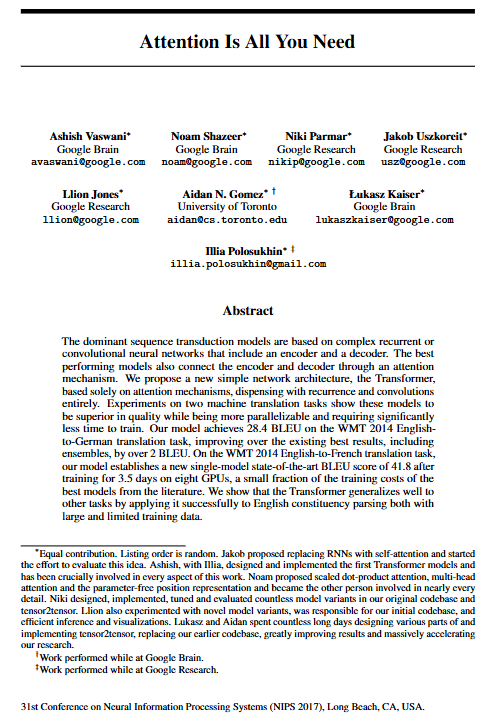

https://arxiv.org/pdf/1706.03762

https://nlp.seas.harvard.edu/annotated-transformer/

Original: Sasha Rush

"""<br>
基于哈佛大学NLP实验室的"The Annotated Transformer"项目<br>
原始作者: Sasha Rush<br>
原始链接: https://nlp.seas.harvard.edu/annotated-transformer/<br>
<br>
本版本: Jupyter Notebook格式 + 中文注释<br>
用途: 教学和学习<br>
"""<br>


本项目修改内容
- 重新整理为Jupyter Notebook格式
- 添加了详细的中文注释
- 优化了代码结构和可读性
- 添加了教学示例和可视化
- 优化了模型配置，支持小规模训练
- 重新整理了项目依赖，经过检验项目能够正常运行

Editor: @SuhanZhang<br>mail:220242544@seu.edu.cn<br>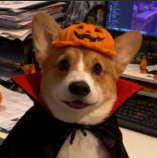<br>You can count on me with this!

## Dependency

In [ ]:
# # Uncomment for colab
# #
# python == 3.9
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


In [ ]:
print(torch.cuda.is_available())

In [ ]:
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook
# 笔记本中使用的一些便捷辅助函数

def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

减少顺序计算的目标，同样是扩展神经 GPU（Extended Neural GPU）、ByteNet 和 ConvS2S 的设计基础 —— 这三种模型均以卷积神经网络为基本构建块，对所有输入和输出位置的隐藏表示进行并行计算。
在这些模型中，关联任意两个输入或输出位置信号所需的运算量，会随位置间距离的增加而增长：ConvS2S 呈线性增长，ByteNet 则呈对数级增长。这使得模型更难学习远距离位置之间的依赖关系。
而在 Transformer 中，这一运算量被缩减为常数级 —— 尽管代价是，对注意力加权位置进行平均会导致有效分辨率降低，我们通过多头注意力机制（Multi-Head Attention）抵消了这一影响。

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

自注意力机制（有时也称为序列内注意力机制）是一种将单个序列的不同位置关联起来以计算序列表示的注意力机制。自注意力机制已成功应用于多种任务，包括阅读理解、抽象式文本摘要、文本蕴含以及学习与任务无关的句子表示。端到端记忆网络基于循环注意力机制而非序列对齐循环，并且已证明在简单语言问答和语言建模任务中表现良好。

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

但据我们所知，Transformer 是第一个完全依靠自注意力机制来计算其输入和输出表示，而无需使用序列对齐的 RNN 或卷积的转换模型。

## Part1:Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, \dots, x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, \dots, z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1, \dots, y_m)$ of symbols one element at a time. At each step the model is auto-regressive (cite), consuming the previously generated symbols as additional input when generating the next.

大多数具有竞争力的神经序列转换模型都采用编码器-解码器结构。其中，编码器将输入的符号表示序列 $(x_1, \dots, x_n)$ 映射到连续表示序列 $\mathbf{z} = (z_1, \dots, z_n)$。给定 $\mathbf{z}$，解码器将 $\mathbf{z}$ 映射到输出的符号序列 $(y_1, \dots, y_m)$。在每个步骤中，模型都是自回归的，在生成下一个符号时，会将先前生成的符号作为额外的输入。

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

Transformer 遵循这种整体架构，编码器和解码器分别采用堆叠式自注意力层和逐点全连接层，如图 1 的左半部分和右半部分所示。

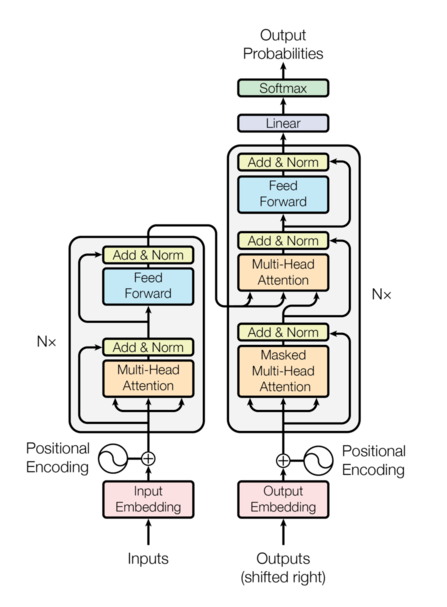

### Encoder and Docoder Stacks<br>编码器和解码器协议栈

Encoder<br>编码器

The encoder is composed of a stack of $N = 6$ identical layers.<br>编码器由$N = 6$个相同的层堆叠形成

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection around each of the two sub-layers, followed by layer normalization.<br>我们在两个子层之间采用残差连接，然后进行层归一化。

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathbf{LayerNorm(x + Sublayer(x))}$, where $\mathbf{Sublayer(x)}$ is the function implemented by the sub-layer itself.We apply dropout (cite) to the output of each sub-layer, before it is added to the sub-layer input and normalized.<br>也就是说，每个子层的输出为$\mathbf{LayerNorm(x + Sublayer(x))}$，其中$\mathbf{Sublayer(x)}$是子层自己实现的函数。我们对每个子层的输出应用 dropout （参见参考文献） ，然后再将其添加到子层输入并进行归一化。

 - $\mathbf{LayerNorm}$(层归一化)：
 是一种深度学习中常用的归一化技术，由Ba et al.在2016年提出。它的主要作用是：
 - 1、__目的__：稳定神经网络的训练过程，加速收敛
 - 2、__原理__：对单个层的所有神经元进行归一化
 - 3、__位置__：通常应用在激活函数之前或之后

 <br>

对于输入向量 $x = (x_1, x_2, ..., x_H)$：

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sigma} + \beta$$

其中：

- $\mu = \frac{1}{H}\sum_{i=1}^{H} x_i$ （均值）

- $\sigma = \sqrt{\frac{1}{H}\sum_{i=1}^{H}(x_i - \mu)^2 + \epsilon}$ （标准差）

- $\gamma$ 和 $\beta$ 是可学习的参数（缩放和偏移）

- $\epsilon$ 是防止除零的小常数

在Transformer中的作用

在Transformer中，LayerNorm至关重要：

- __稳定训练__：防止梯度消失/爆炸
- __加速收敛__：使训练更加稳定和快速
- __残差连接配合__：与残差连接完美配合，形成"Add & Norm"结构


To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$.<br>为了促进这些残余连接，模型中的所有子层以及嵌入层都产生维度为$d_{model} = 512$的输出。

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.<br>每一层都有两个子层。第一层是多头自注意力机制，第二层是一个简单的、按位置全连接的前馈网络。

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

Decoder<br>解码器

The decoder is also composed of a stack of $N = 6$ identical layers.<br>解码器也由$N = 6$个相同的层堆叠形成。

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.<br>除了每个编码器层中的两个子层之外，解码器还插入了第三个子层，该子层对编码器堆栈的输出执行多头注意力机制。与编码器类似，我们在每个子层周围都使用了残差连接，然后进行层归一化。

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.<br>我们还修改了解码器堆栈中的自注意力子层，以防止位置信息影响后续位置信息。这种掩蔽机制，结合输出嵌入偏移一个位置的事实，确保位置$i$的预测结果仅依赖于位置 $i$ 之前的已知输出。

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.<br>注意力掩码下方显示了每个目标词（行）允许关注的位置（列）。在训练期间，单词会被屏蔽，无法关注后续单词。

In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

expected output:
<br><br>
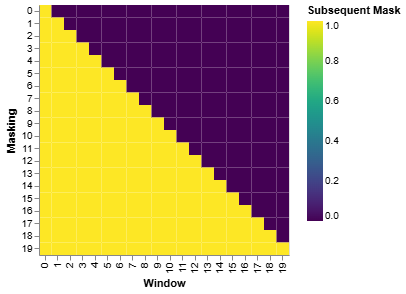

### Attention<br>注意力机制

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.<br>注意力函数可以描述为将查询和一组键值对映射到输出，其中查询、键、值和输出都是向量。输出计算为值的加权和，每个值的权重由查询与其对应键的兼容性函数计算得出。

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, devide each by $\sqrt{d_k}$,  and apply a softmax function to obtain the weights on the values.<br>我们将这种特殊的注意力机制称为“缩放点积注意力”。输入由维度为 $d$ 的查询（queries）和键（keys）以及维度为 $d_v$ 的值（values）组成。我们首先计算查询与所有键的点积，然后除以 $\sqrt{d_k}$，最后使用 softmax 函数来获得值的权重。

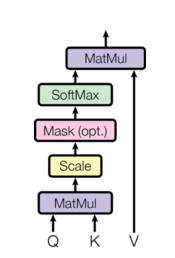

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix ${Q}$.The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:<br>在实践中，我们会同时计算一组查询的注意力函数，并将其打包成矩阵${Q}$。键和值也打包成矩阵$K$和$V$。 我们计算输出矩阵为：

$ \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V $

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention (cite), and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention is more complex and has a longer computational cost, but can be stabilized by scaling the query and key matrices.Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.<br>两种最常用的注意力函数是加性注意力（见引用）和点积（乘法）注意力。点积注意力与我们的算法基本一致，仅在缩放因子 $\frac{1}{\sqrt{d_k}}$ 上有所不同。加性注意力通过一个含单隐藏层的前馈网络来计算兼容性函数。尽管二者在理论复杂度上相近，但在实际应用中，点积注意力因可通过高度优化的矩阵乘法代码实现，所以速度更快、空间效率也更高。

> - Additive attention（加性注意力）：一种注意力机制，通过前馈网络计算注意力权重，适用于查询和键维度不同的场景。
> - Dot-product attention（点积注意力）：通过查询与键的点积计算相似度，是 Transformer 等模型的核心注意力形式，本文中 “缩放点积注意力” 是其带缩放因子的优化版本。
> - Feed-forward network（前馈网络）：无循环连接的神经网络结构，常用于注意力、Transformer 的全连接层等模块。

While for small values of $d_{k}$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_{k}$ (cite). We suspect that for large values of $d_{k}$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean 0 and variance 1. Then their dot product, $q \cdot k = \sum_{i=1}^{d_{k}} q_{i} k_{i}$, has mean 0 and variance $d_{k}$). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_{k}}}$.<br>虽然对于较小的 $ d_{k} $ 值，两种机制表现相似，但对于较大的 $ d_{k} $ 值，加性注意力优于未缩放的点积注意力（引用）。我们猜测，对于较大的 $ d_{k} $ 值，点积的幅度会变大，将 softmax 函数推入梯度极小的区域（为了说明点积为何变大，假设 q 和 k 的分量是均值为 0、方差为 1 的独立随机变量。那么它们的点积 $ q\cdot k=\sum_{i=1}^{d_{k}}q_{i}k_{i} $ 的均值为 0，方差为 $ d_{k} $）。为了抵消这种效应，我们将点积缩放 $ \frac{1}{\sqrt{d_{k}}} $。


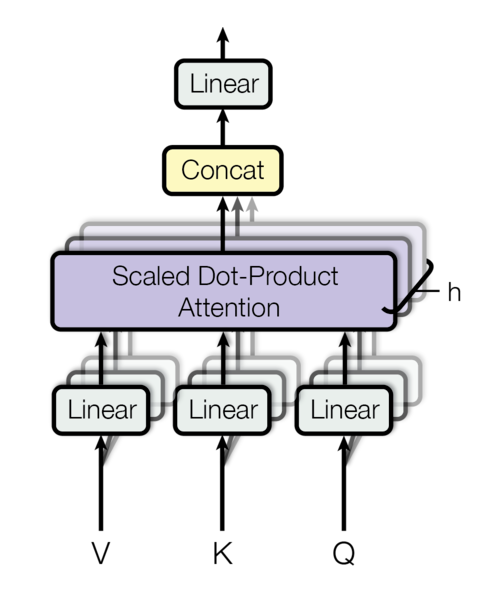

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.<br>多头注意力机制允许模型同时关注来自不同表征子空间、位于不同位置的信息。而单头注意力机制则会通过平均来抑制这种能力。

多头注意力机制（Multi-Head Attention）的定义如下：

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O $$

其中每一个注意力头（head）的计算方式为：

$$ \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V) $$

公式中所使用的投影参数矩阵及其维度为：
- $W_i^Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W_i^K \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_v}$
- $W^O \in \mathbb{R}^{h d_v \times d_{\text{model}}}$

In this work we employ $h = 8$ parallel attention layers, or heads. For each of these we use $d_k = d_{model}/h = 64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.<br>在本研究中，我们采用了$h = 8$并行注意力层（或称注意力头）。对于每个注意力头，我们使用$d_k = d_{model}/h = 64$。由于每个头的维度较小，因此总计算成本与全维度单注意力头的计算成本相似。

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

### Applications of Attention in our Model<br>注意力机制在我们模型中的应用

The Transformer uses multi-head attention in three different ways: 1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [Cite](https://arxiv.org/abs/1609.08144).<br>Transformer 模型以三种不同的方式使用多头注意力机制：1）在“编码器-解码器注意力”层中，查询来自前一个解码器层，记忆键和值来自编码器的输出。这使得解码器中的每个位置都能关注输入序列中的所有位置。这模拟了序列到序列模型（例如 [参考文献](https://arxiv.org/abs/1609.08144)） 中典型的编码器-解码器注意力机制。

The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.<br>编码器包含自注意力层。在自注意力层中，所有键、值和查询都来自同一位置，在本例中，即编码器前一层的输出。编码器中的每个位置都可以关注其前一层中的所有位置。

### Position-wise Feed-Forward Networks<br>位置前馈网络

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a $\mathbf{ReLU}$ activation in between.<br>除了注意力子层之外，我们的编码器和解码器中的每一层都包含一个全连接前馈网络，该网络分别且相同地应用于每个位置。它由两个线性变换组成，中间夹有 $\mathbf{ReLU}$ 激活函数。

$$ \text{FFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2 $$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_model = 512$,  and the inner-layer has dimensionality $d_{ff} = 2048$.<br>虽然线性变换在不同位置上相同，但它们在不同层使用不同的参数。另一种描述方式是将其描述为两个核大小为 1 的卷积。输入和输出的维度为$d_model = 512$，内层的维度为$d_{ff} = 2048$。

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

### Embeddings and Softmax<br>嵌入和 $\text{Softmax}$

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.<br>与其他序列转换模型类似，我们使用学习得到的嵌入（embeddings）将输入标记（tokens）和输出标记转换为维度是 $ d_{\text{model}} $ 的向量。我们同样使用常用的学习得到的线性变换和 softmax 函数来将解码器输出转换为预测的下一个标记的概率。在我们的模型中，我们让两个嵌入层和 softmax 前的线性变换共享相同的权重矩阵，类似于（引用）。在嵌入层中，我们将这些权重乘以 $ \sqrt{d_{\text{model}}} $。

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Position Encoding<br>位置编码

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf).<br>由于我们的模型不包含循环（recurrence）和卷积（convolution）结构，为了让模型能够利用序列的顺序信息，我们必须注入一些关于序列中标记（tokens）的相对或绝对位置的信息。为此，我们在编码器和解码器堆栈的底部，将“位置编码”（positional encodings）添加到输入嵌入（input embeddings）中。位置编码与嵌入具有相同的维度 $ d_{\text{model}} $，因此两者可以相加。位置编码有很多种选择，可以是学习得到的，也可以是固定的[(引用)](https://arxiv.org/pdf/1705.03122.pdf)。


In this work, we use sine and cosine functions of different frequencies:<br>在这项工作中，我们使用了不同频率的正弦和余弦函数：

$$
\begin{aligned}
PE_{(pos,2i)}   &= \sin\left(pos / 10000^{2i / d_{model}}\right) \\
PE_{(pos,2i+1)} &= \cos\left(pos / 10000^{2i / d_{model}}\right)
\end{aligned}

where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.
<br>
其中 $pos$ 是位置，$i$ 是维度。也就是说，位置编码的每个维度对应一个正弦曲线。其波长构成了一个从 $2\pi$ 到 $10000 \cdot 2\pi$ 的几何级数。我们选择这个函数是因为我们假设，对于任何固定的偏移量 $k$，$PE_{pos+k}$ 都可以表示为 $PE_{pos}$ 的一个线性函数，这使得模型能够很容易地学会根据相对位置进行关注。


In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of $P_{drop} = 0.1$.
<br>
此外，我们对编码器和解码器堆栈中的嵌入向量和位置编码之和都应用了 dropout。对于基础模型，我们使用的 dropout 率为$P_{drop} = 0.1$。

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.
<br>
在位置编码下方，会根据位置添加一个正弦波。每个维度的波形频率和偏移量都不同。

In this work, we use sine and cosine functions of different frequencies:<br>
在这项工作中，我们使用了不同频率的正弦和余弦函数：

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

We also experimented with using learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.
<br>
我们还尝试使用学习到的位置嵌入 [（参考文献）](https://arxiv.org/pdf/1705.03122.pdf) ，发现两种方法得到的结果几乎相同。我们选择正弦嵌入是因为它可以让模型外推到比训练过程中遇到的序列长度更长的序列。

### Full Model<br>
<br>
Here we define a function from hyperparameters to a full model.
<br>
在这里，我们定义了一个从超参数到完整模型的函数。

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### Inference:<br>推理：
<br>
Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.
<br>
在这里，我们进行一次前向迭代，生成模型的预测结果。我们尝试使用 Transformer 来记忆输入。正如你所看到的，由于模型尚未训练，输出是随机生成的。在下一个教程中，我们将构建训练函数，并尝试训练模型来记忆 1 到 10 之间的数字。

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

expected output:
<br><br>
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])<br>
Example Untrained Model Prediction: tensor([[0, 3, 4, 4, 4, 4, 4, 4, 4, 4]])<br>
Example Untrained Model Prediction: tensor([[ 0, 10, 10, 10,  3,  2,  5,  7,  9,  6]])<br>
Example Untrained Model Prediction: tensor([[ 0,  4,  3,  6, 10, 10,  2,  6,  2,  2]])<br>
Example Untrained Model Prediction: tensor([[ 0,  9,  0,  1,  5, 10,  1,  5, 10,  6]])<br>
Example Untrained Model Prediction: tensor([[ 0,  1,  5,  1, 10,  1, 10, 10, 10, 10]])<br>
Example Untrained Model Prediction: tensor([[ 0,  1, 10,  9,  9,  9,  9,  9,  1,  5]])<br>
Example Untrained Model Prediction: tensor([[ 0,  3,  1,  5, 10, 10, 10, 10, 10, 10]])<br>
Example Untrained Model Prediction: tensor([[ 0,  3,  5, 10,  5, 10,  4,  2,  4,  2]])<br>
Example Untrained Model Prediction: tensor([[0, 5, 6, 2, 5, 6, 2, 6, 2, 2]])<br>

## Part 2: Model Training<br>第二部分：模型训练

### Training<br>训练
<p>We stop for a quick interlude to introduce some of the tools needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.<br>我们先简要介绍一下训练标准编码器-解码器模型所需的一些工具。首先，我们定义一个批处理对象，其中包含用于训练的源语句和目标语句，以及用于构建掩码的对象。</p>

Batches and Masking
<br>批次和掩码

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.
<br>
接下来，我们创建一个通用的训练和评分函数来跟踪损失。我们传入一个通用的损失计算函数，该函数也负责处理参数更新。

### Training Loop

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed


In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state


### Training Data and Batching<br>训练数据和批量处理

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs. Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.
<br>
我们使用包含约 450 万个句子对的标准 WMT 2014 英德数据集进行训练。句子采用字节对编码，其源语言和目标语言共享词汇表约 37000 个词元。对于英法双语，我们使用了规模更大的 WMT 2014 英法双语数据集，该数据集包含 3600 万个句子，并将词元拆分为 32000 个词段的词汇表。

Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.
<br>
句子对按大致序列长度进行分组。每个训练批次包含一组句子对，其中大约包含 25000 个源词元和 25000 个目标词元。

Hardware and Schedule <BR> 训练硬件与训练过程
<p>We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds. We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).
<br>
我们在一台配备 8 个 NVIDIA P100 GPU 的机器上训练模型。对于本文所述的超参数基础模型，每个训练步骤耗时约 0.4 秒。基础模型总共训练了 10 万步，耗时 12 小时。对于大型模型，每步耗时 1.0 秒。大型模型训练了 30 万步（3.5 天）。</p>

Optimizer = torch.optim.Adam
<br>
We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980) with $β_1 = 0.9$, $β_2 = 0.98$ and $ϵ = 10^{-9}$. We varied the learning rate over the course of training, according to the formula:<br>
我们使用 Adam 优化器 [（参考文献）](https://arxiv.org/abs/1412.6980)， 参数分别为 $β_1 = 0.9$, $β_2 = 0.98$ 和 $ϵ = 10^{-9}$。在训练过程中，我们根据以下公式调整学习率：

$$ \text{lrate} = d^{-0.5}_{model}\cdot \text{min}(step\_num^{-0.5}, step\_num\cdot warmup\_steps^{-1.5}) $$

This corresponds to increasing the learning rate linearly for the first $warmup$ $steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used $warmup$ $steps = 4000$.
<br>

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )


In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

expected output:<br><br>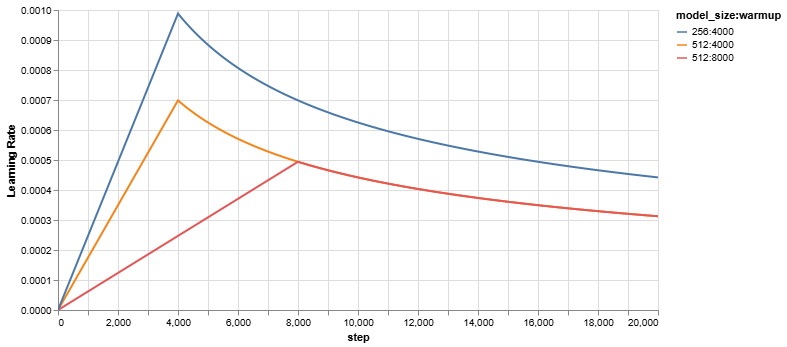

### Regularization<br>正则化

Lable Smoothing<br>标签平滑
<br><br>
During training, we employed label smoothing of value $ϵ_{ls} = 0.1$[(cite)](https://arxiv.org/abs/1512.00567). This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.<br>在训练过程中，我们采用了标签平滑法，将标签值设为$ϵ_{ls} = 0.1$[(cite)](https://arxiv.org/abs/1512.00567)。这虽然会降低模型的复杂度（perplexity）（因为模型会学习到更多的不确定性），但可以提高准确率和$\mathbf{BLEU}$评分
<br><br>
We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.
<br>
我们使用KL散度损失 $\mathbf{KL div loss}$ 来实现标签平滑。我们没有使用独热目标分布(One-hot target distribution)，而是创建了一种新分布，该分布包含正确单词的置信度(confidence)，其余平滑量(smoothing mass)分量则分布在整个词汇表中。

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


Here we can see an example of how the mass is distributed to the words based on confidence.<br>在这里我们可以看到，根据置信度(confidence)，质量(mass)是如何分配给各个词语的。

In [ ]:
# Example of label smoothing.


def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)


expected output:<br><br>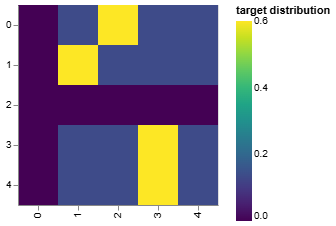

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.
<br>
标签平滑（label smoothing）的实际作用是：如果模型对某个特定选择过于自信，它就会开始对模型进行惩罚。

In [ ]:

def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)


expected output:<br><br>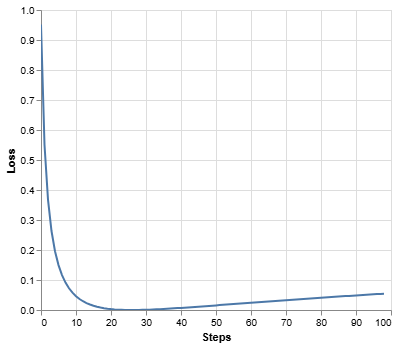

### A First Example<br>例一
<p>We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.
<br>
我们可以从尝试一个简单的复制任务（copy-task） 开始。给定一组来自小型词汇表的随机输入符号，任务目标是生成出相同的符号。

Synthetic Data<br>数据合成

In [ ]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

Loss Computation<br>计算损失

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

Greedy Decoding<br>贪心解码
<p>This code predicts a translation using greedy decoding for simplicity.
<br>
为简化起见，该代码采用贪心解码（greedy decoding） 来预测译文。</p>

 - 贪心解码（greedy decoding）
<br>
核心逻辑：解码过程中每一步都选择当前概率最高的输出 token（如单词、子词），不回溯调整之前的选择。
<br>
特点：实现简单、计算效率高，适合快速验证模型效果。
<br>
翻译场景适配：在机器翻译中，它会逐词选择概率最优项拼接成译文，无需考虑后续词的组合效果。
<br>
局限性：可能因局部最优导致全局译文质量下降，比如错过整体更通顺的搭配。

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [ ]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model)

## Part3: A Real World Example<br>第三部分： 一个实际案例
<P>Now we consider a real-world example using the Multi30k German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.<br>现在我们来看一个实际的例子，即 Multi30k 德英翻译任务。这个任务比论文中讨论的 WMT 任务规模小得多，但它足以说明整个系统。我们还会展示如何利用多 GPU 处理来大幅提升速度。

Data Loading
<p>
We will load the dataset using torchtext and spacy for tokenization.
<br>
我们将使用 torchtext 和 spacy 加载数据集进行分词。
</p>

In [ ]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already


#def load_tokenizers():
#
#    try:
#        spacy_de = spacy.load("de_core_news_sm")
#    except IOError:
#        os.system("python -m spacy download de_core_news_sm")
#        spacy_de = spacy.load("de_core_news_sm")
#
#    try:
#        spacy_en = spacy.load("en_core_web_sm")
#    except IOError:
#        os.system("python -m spacy download en_core_web_sm")
#        spacy_en = spacy.load("en_core_web_sm")
#
#    return spacy_de, spacy_en


#本项目使用uv环境构建，所以把pip install改为uv pip install

#def load_tokenizers():
#    try:
#        spacy_de = spacy.load("de_core_news_sm")
#    except IOError:
#        # 使用uv命令下载
#        import subprocess
#        subprocess.run(["uv", "run", "python", "-m", "spacy", "download", "de_core_news_sm"], check=True)
#       spacy_de = spacy.load("de_core_news_sm")
#
#    try:
#        spacy_en = spacy.load("en_core_web_sm")
#    except IOError:
#        subprocess.run(["uv", "run", "python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
#        spacy_en = spacy.load("en_core_web_sm")
#
#    return spacy_de, spacy_en

In [ ]:
#因为服务器上不了github，所以我们在下载数据集后跳过下载tokenizer模型这一步

#手动下载步骤
#source ~/STUDY/TheAnnotatedTransformer/.venv/bin/activate
#uv pip install https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0.tar.gz
#uv pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0.tar.gz

def load_tokenizers():
    # 假设模型已经手动安装
    spacy_de = spacy.load("de_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")
    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])


expected output:
<br><br>
Finished.<br>
Vocabulary sizes:<br>
59981<br>
36745

Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches.
<br>
批处理（Batching）对速度至关重要。我们希望得到划分极其均匀的批次，同时填充量（padding）尽可能少。要实现这一点，我们需要对 torchtext 的默认批处理逻辑稍作修改。该代码修补了其默认批处理方式，确保会搜索足够多的句子，以找到紧凑的批次（tight batches）。

Iterators<br>迭代器

In [ ]:
def collate_batch(s
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)


In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader


Training the System
<br>
训练系统

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model()

Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate.<br>模型训练完成后，我们可以对其进行解码，生成一系列翻译结果。这里我们只翻译验证集中的第一个句子。由于该数据集较小，因此使用贪心搜索算法得到的翻译结果相当准确。

## Additional Components: BPE, Search, Averaging<br>其他组件：BPE、搜索、平均值

So this mostly covers the transformer model itself. There are four aspects that we didn’t cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).<br>以上内容基本涵盖了 Transformer 模型本身。还有四个方面我们没有明确提及。此外， [OpenNMT-py](https://github.com/opennmt/opennmt-py) 中也实现了所有这些附加功能。

BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich’s [subword-nmt](https://github.com/rsennrich/subword-nmt) implementation. These models will transform the training data to look like this:
<br>
BPE/词片：我们可以使用一个库先将数据预处理成子词单元。参见 Rico Sennrich 的 [subword-nmt](https://github.com/rsennrich/subword-nmt) 实现。这些模型会将训练数据转换成如下所示的形式：


▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .
<br>日志文件可以通过电子邮件或 FTP 秘密发送给特定收件人。

Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:
<br>
共享词嵌入：当使用带有共享词汇表的 BPE 时，我们可以在源节点、目标节点和生成器之间共享相同的权重向量。详情请参见 [（引用）](<https://arxiv.org/abs/1608.05859>) 。要将此功能添加到模型中，只需执行以下操作：

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/) for a pytorch implementation.
<br>
束搜索：这部分内容比较复杂，这里无法详细介绍。您可以参考 [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/) 获取 PyTorch 实现。

Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:
<br>
模型平均：该论文对最后 k 个检查点进行平均，以产生集成效应。如果我们有很多模型，也可以事后进行此操作：

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        ps[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

## Results<br>结果

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big) in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0 BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model surpasses all previously published models and ensembles, at a fraction of the training cost of any of the competitive models.
<br>
在 WMT 2014 英德翻译任务上，大型 Transformer 模型（表 2 中的 Transformer (big)）的性能比之前报道的最佳模型（包括集成模型）高出 2.0 以上 BLEU 值，创造了 28.4 的全新 BLEU 最佳成绩。该模型的配置列于表 3 的最后一行。训练耗时 3.5 天，使用了 8 个 P100 GPU。即使是我们的基础模型，其性能也超越了所有已发表的模型和集成模型，而训练成本却远低于任何竞争模型。

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0, outperforming all of the previously published single models, at less than 1/4 the training cost of the previous state-of-the-art model. The Transformer (big) model trained for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.
在 WMT 2014 英译法任务上，我们的大型模型取得了 41.0 的 BLEU 分数，优于所有已发表的单模型，且训练成本不到之前最先进模型的四分之一。用于英译法任务的 Transformer（大型）模型使用了 0.1 的 dropout 率 Pdrop，而非 0.3。

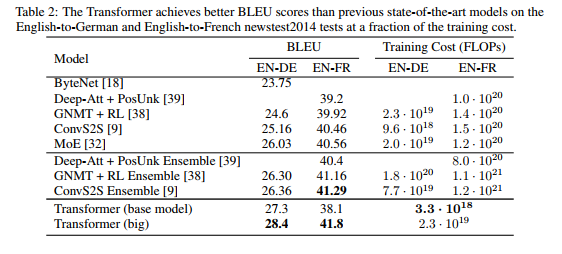

With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation.
<br>
加上上一节中提到的扩展，OpenNMT-py 在 EN-DE WMT 上的复现精度达到了 26.9。这里我已将这些参数加载到我们的重新实现中。

In [ ]:
# Load data and model for output checks

In [ ]:
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


# execute_example(run_model_example)

Attention Visualization
<Br>
注意力可视化

Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention
<br>
即使使用贪婪解码器，翻译结果看起来也相当不错。我们可以进一步将其可视化，以了解注意力机制每一层发生的情况。

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [ ]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

Encoder Self Attention
<br>
编码器自注意力

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

expected outputs:
<br><br>
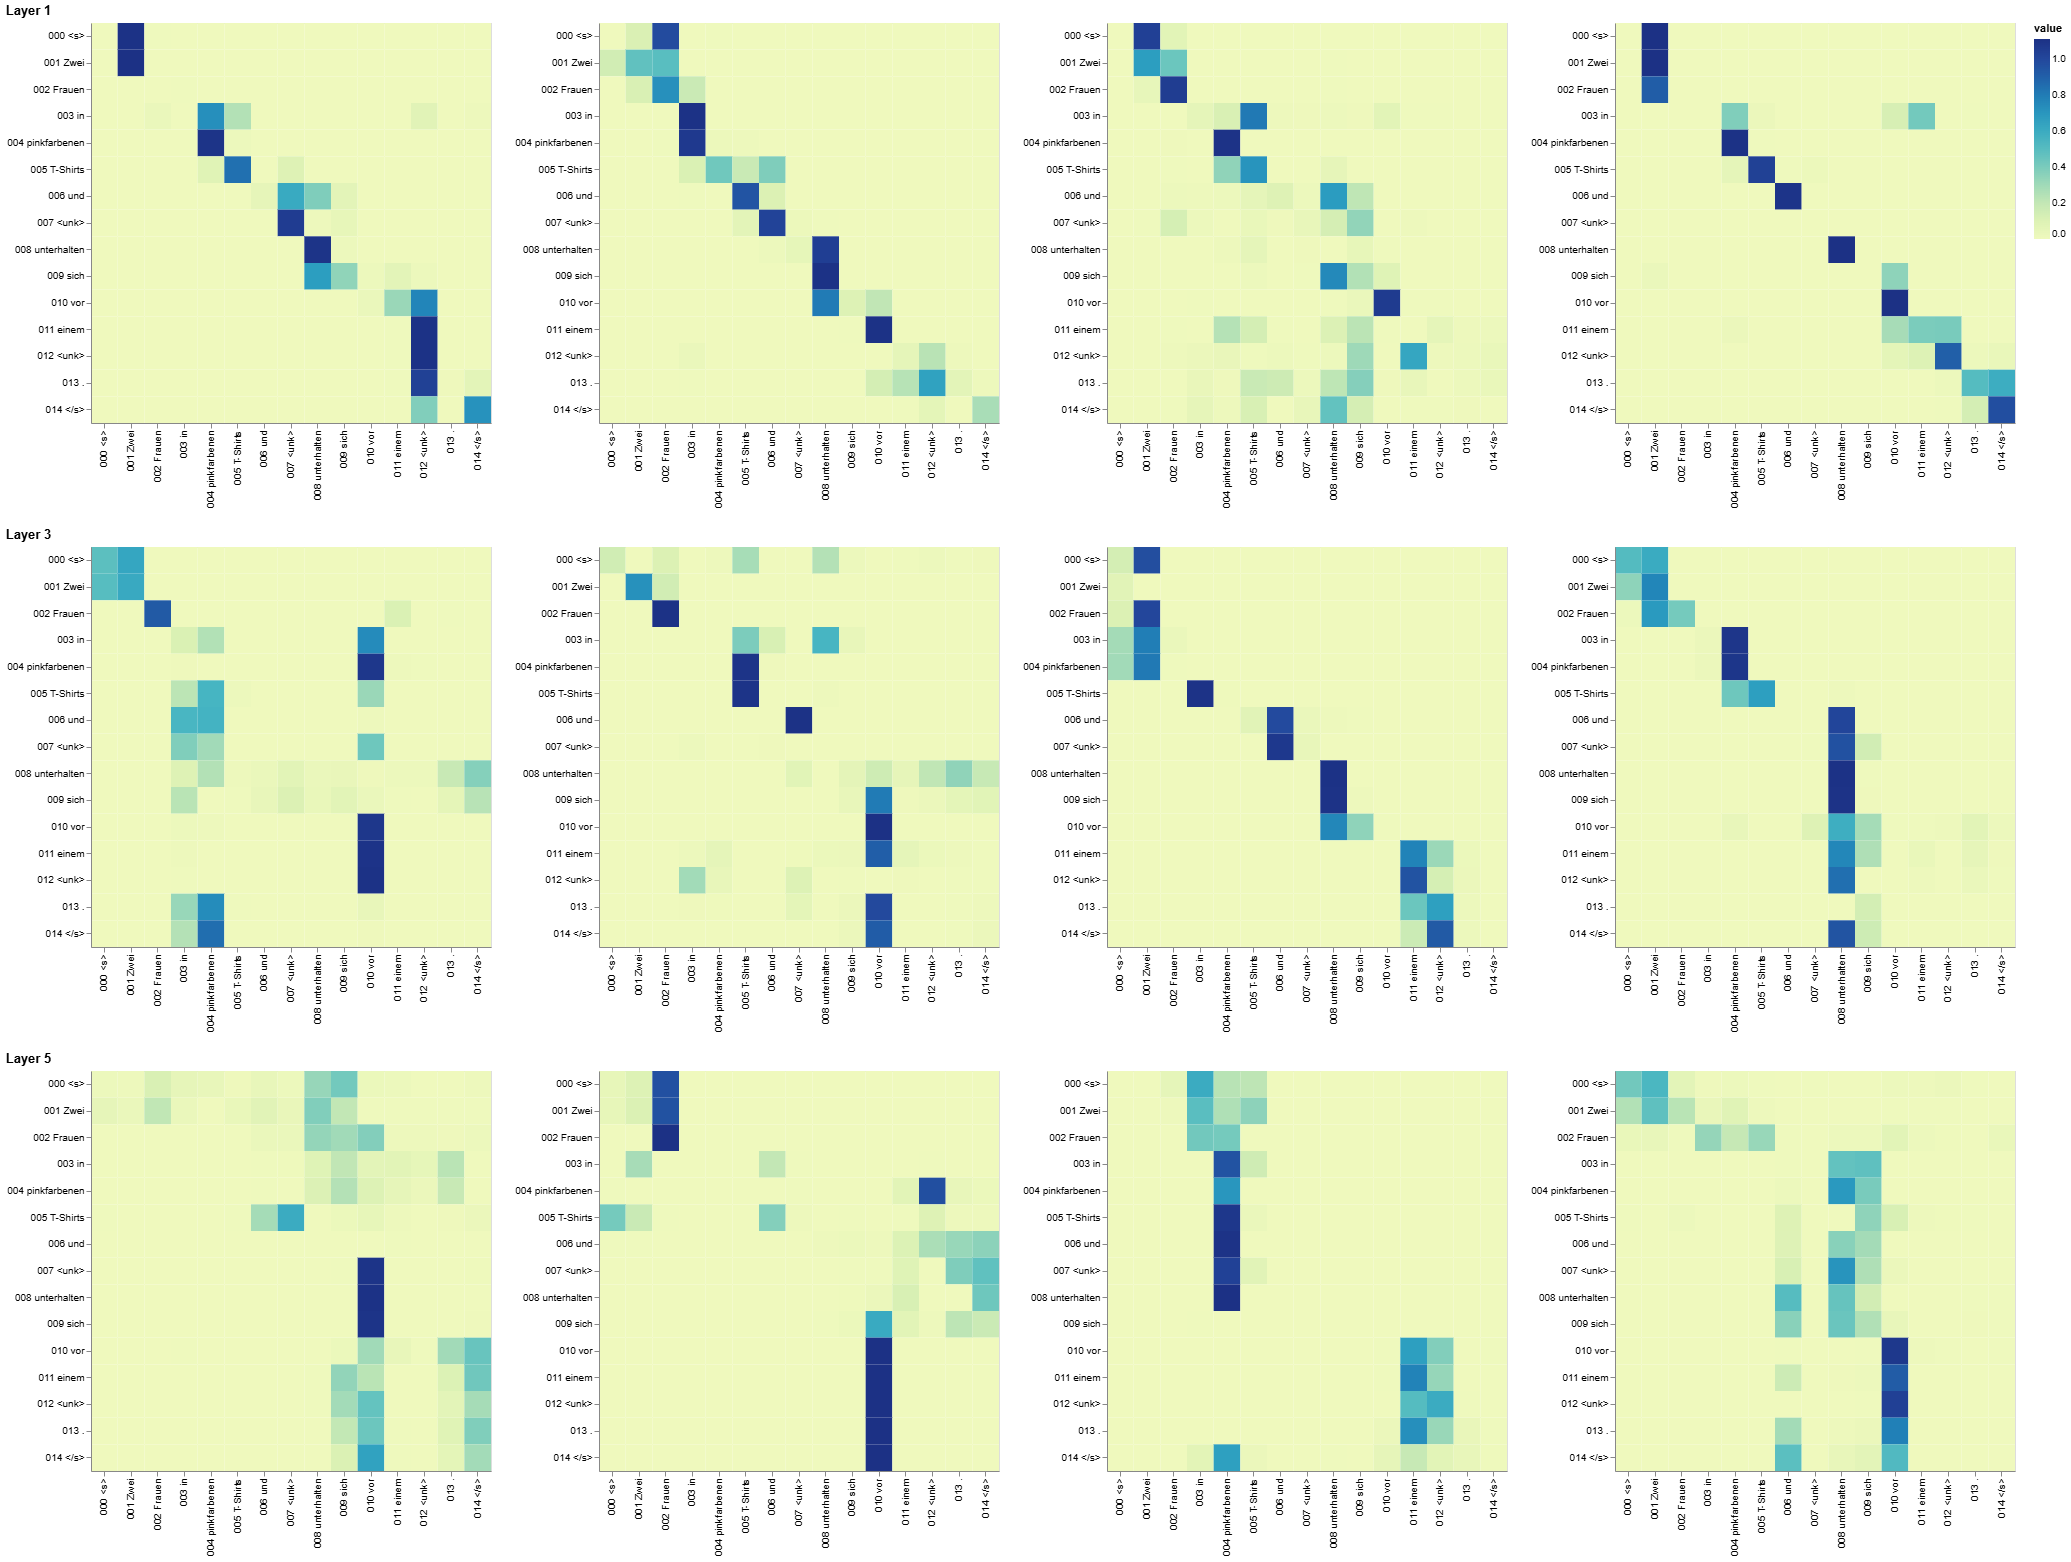

Decoder Self Attention<br>解码器自我注意力


In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

expected outputs:
<br><br>
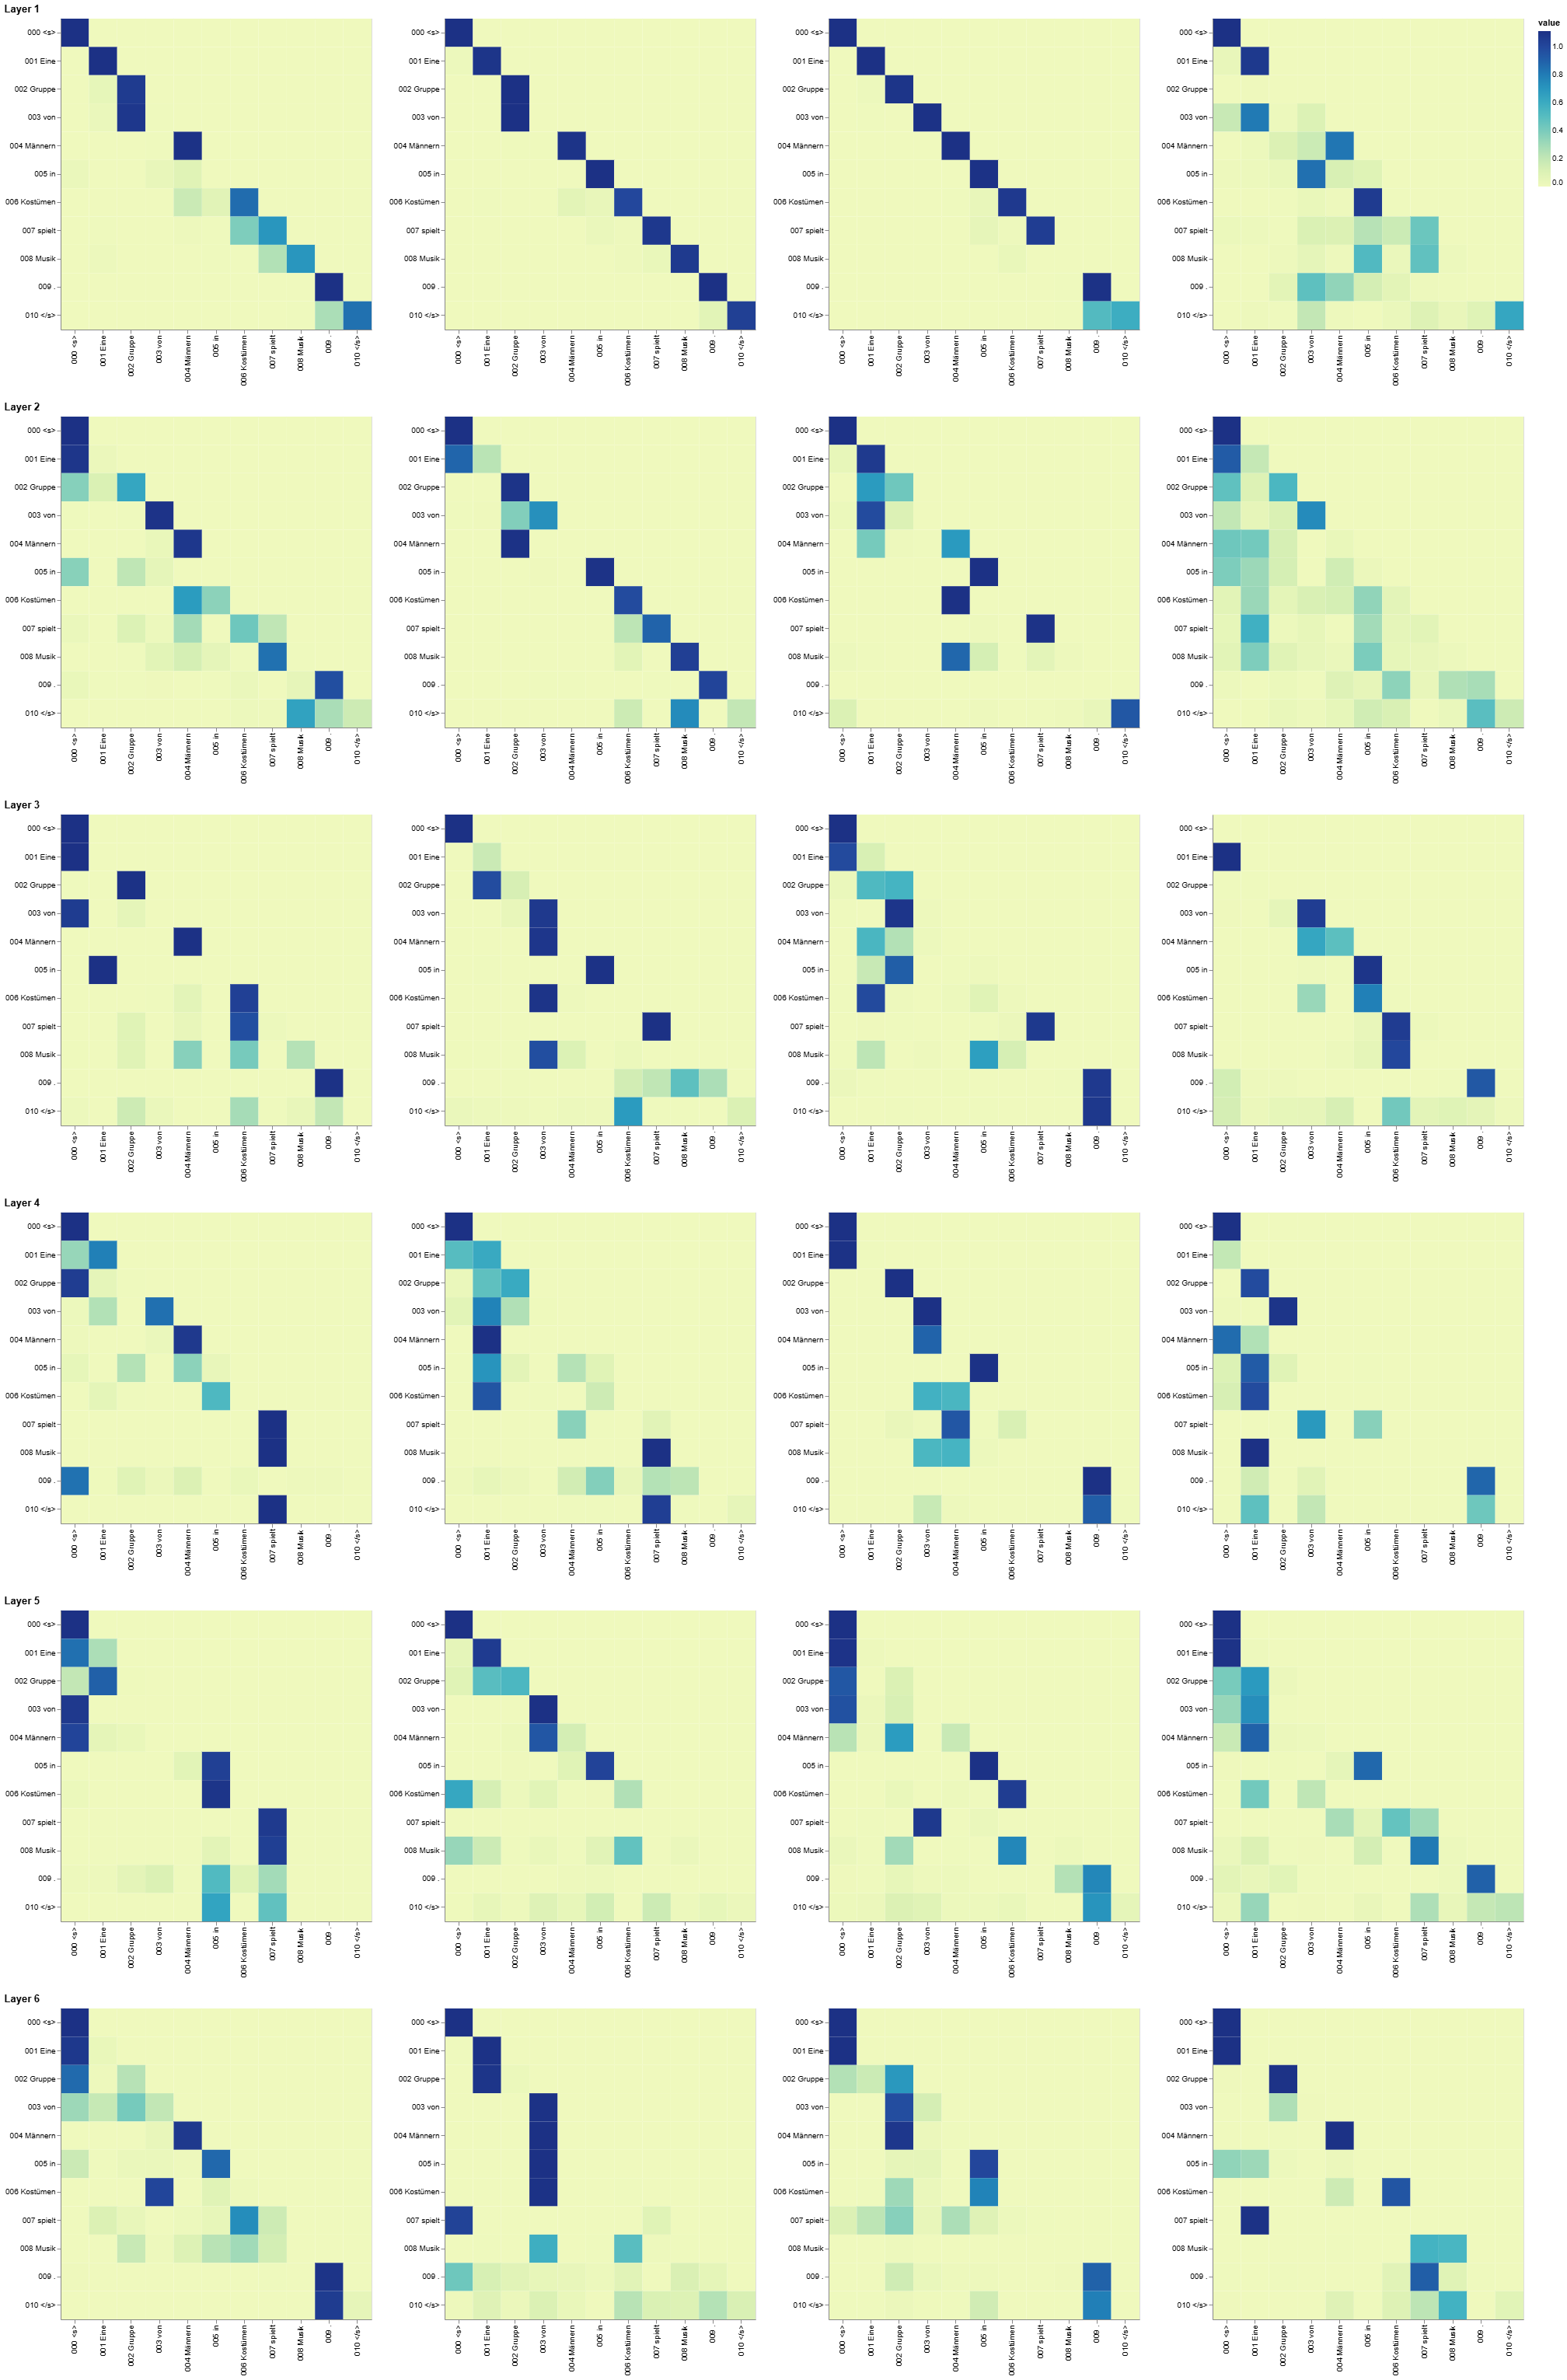

Decoder Src Attention<br>码器源注意力

In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)

expected outputs:
<br><br>
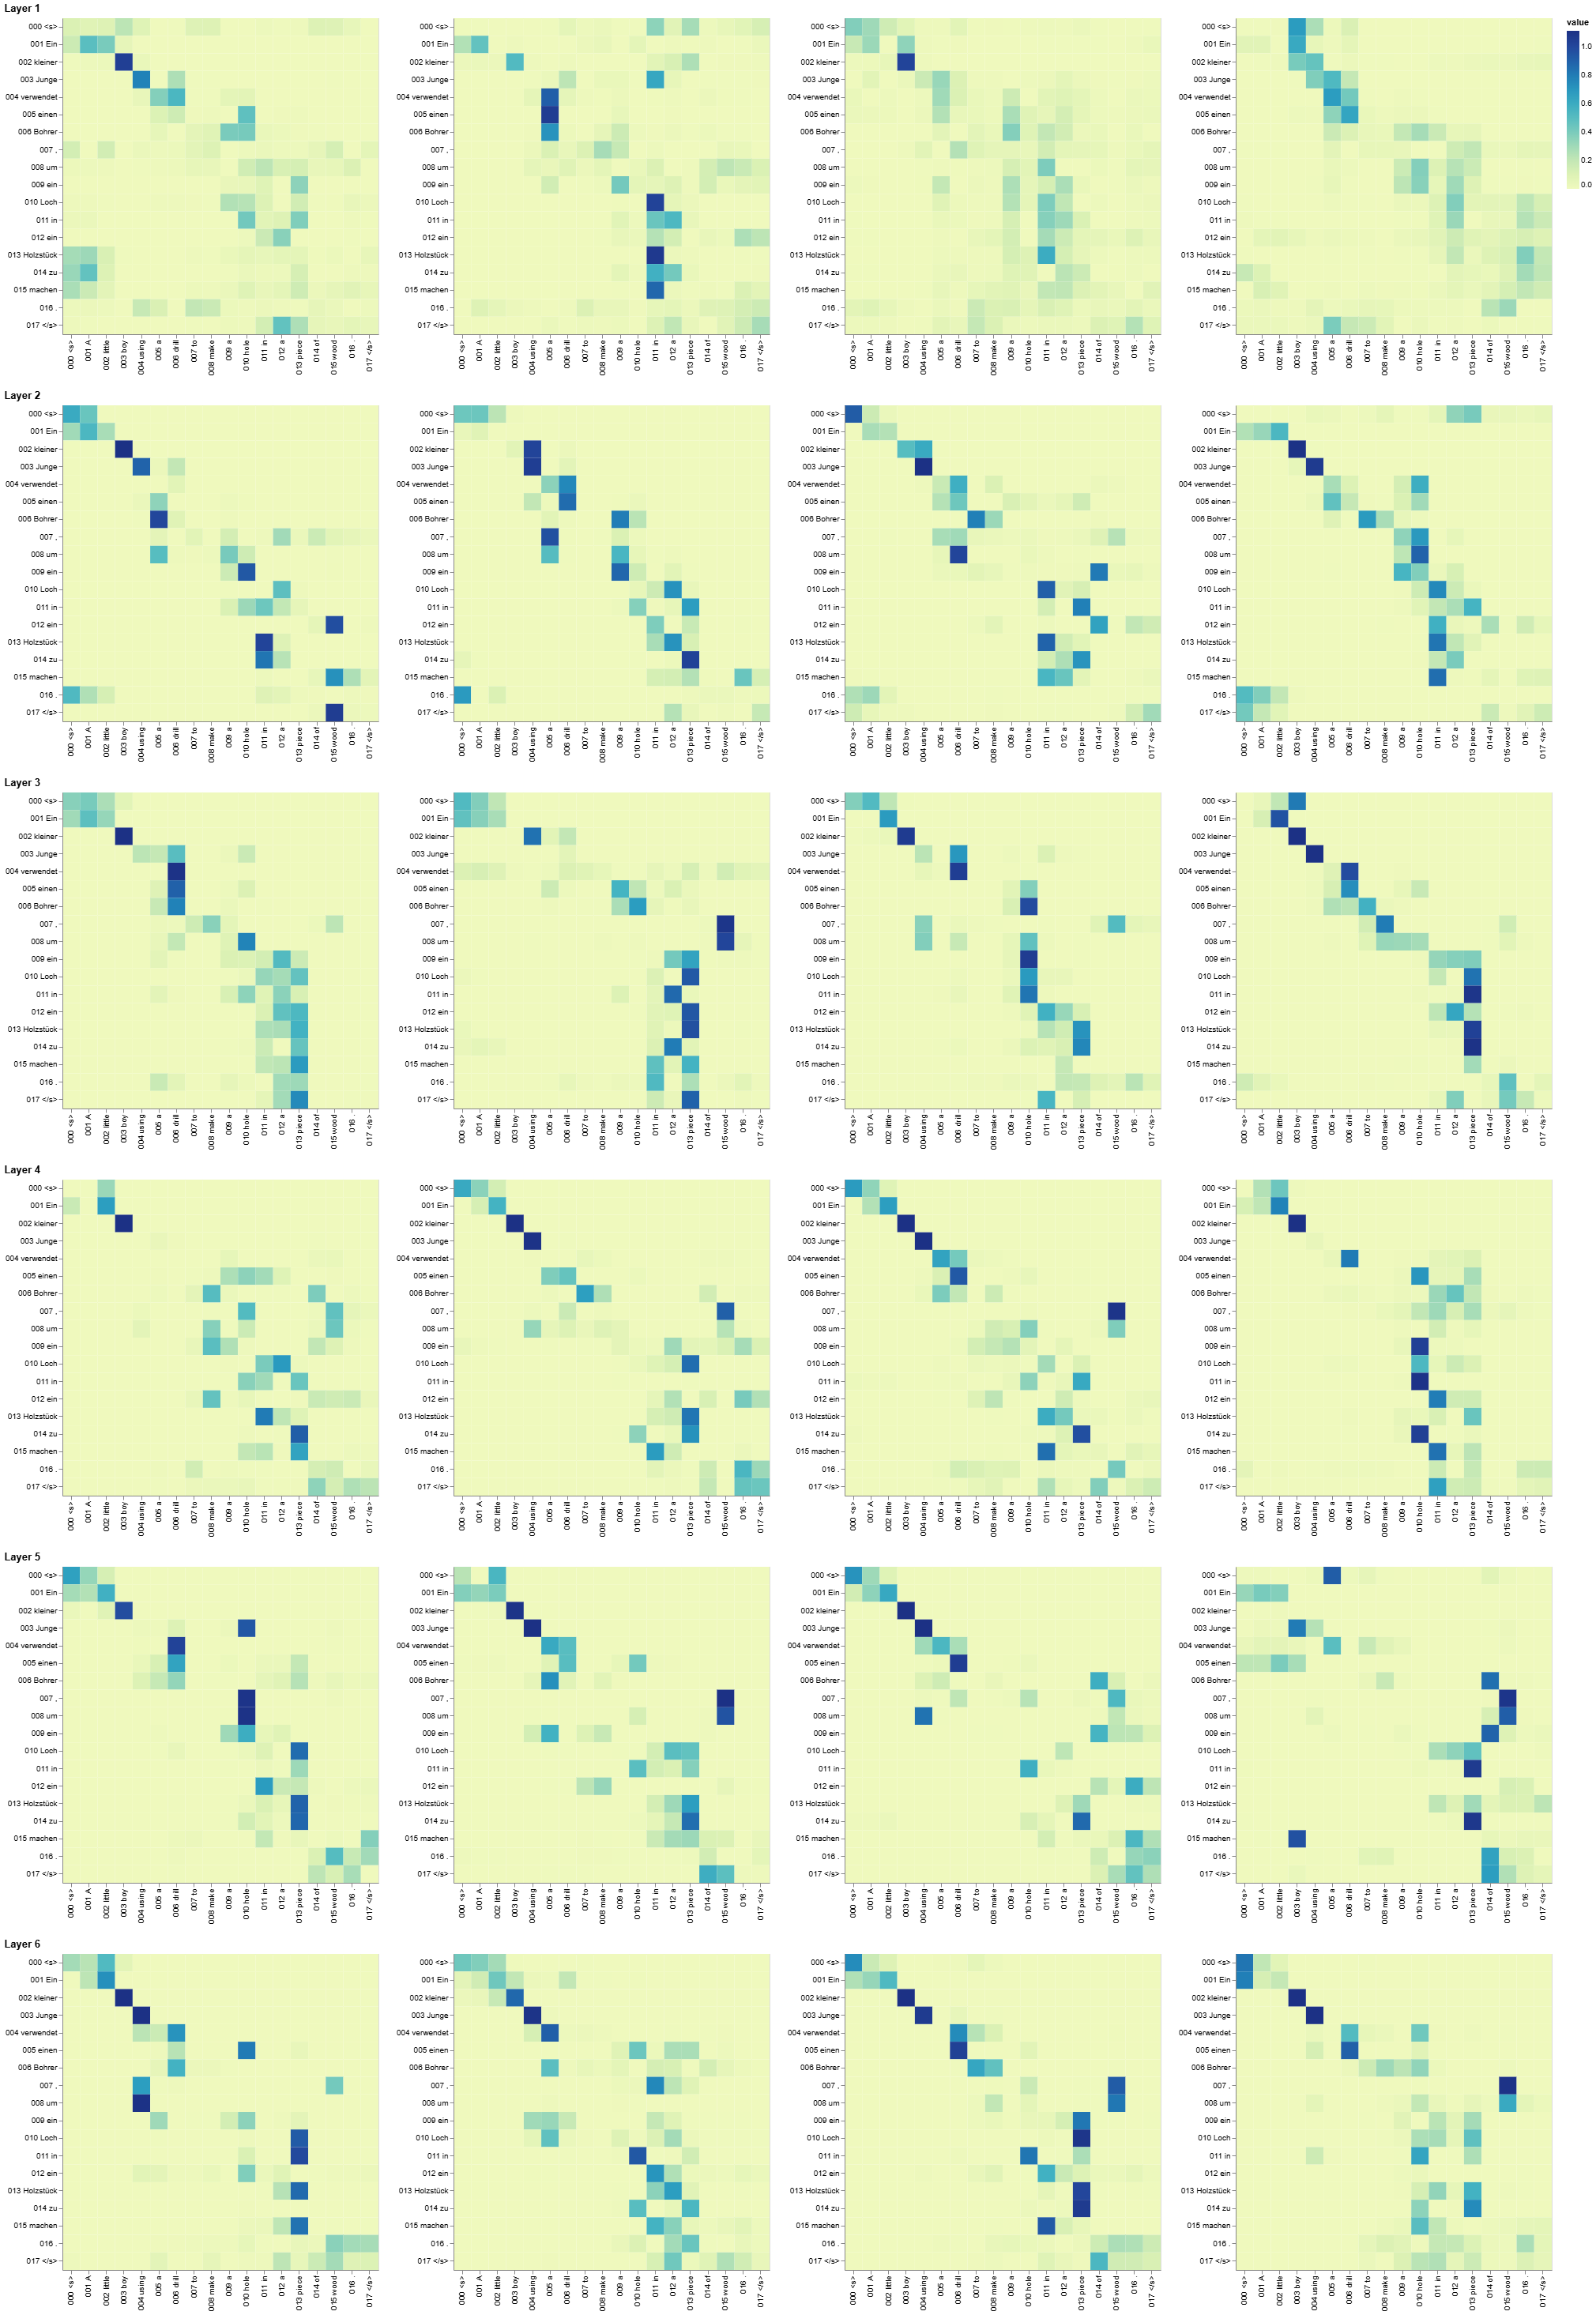